In [2]:
import pandas as pd
import datetime
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import os

## Proceso de Creación del Dataframe - S&P500 - [2000 - 2021]

In [10]:
files = files = os.listdir(os.getcwd())
if 'Proyecto_2.csv' in files:
    print('File has already been created')
else:
    wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(wiki_url)
    soup = BeautifulSoup(response.text,'lxml')
    tickers_list = soup.find('table',attrs={'class':"wikitable sortable"})
    df = pd.read_html(str(tickers_list))[0]
    df.to_csv(r'C:\Users\usuario\Desktop\Proyects\Proyecto_2\Proyecto_2.csv', index = False)

File has already been created


In [3]:
source = r"C:\Users\usuario\Desktop\Proyects\Proyecto_2\Proyecto_2.csv"
try:
    df_tickers = pd.read_csv(source,sep=',')
except:
    df_tickers = pd.read_csv(source,sep=',', encoding="ISO-8859-1")

In [4]:
lista_tickers = df_tickers['Symbol'].tolist()
lista_sector = df_tickers['GICS Sector'].tolist()

In [5]:
df = pd.DataFrame()
for ticker,sector in zip(lista_tickers,lista_sector):
    data = yf.download(ticker, start="2000-01-01", end="2021-12-31",progress=False)
    data.reset_index(inplace=True)
    data['Ticker'] = ticker
    data['Sector'] = sector
    df = pd.concat([data,df],ignore_index=True)


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted

1 Failed download:
- CEG: Data doesn't exist for startDate = 946681200, endDate = 1640905200


In [6]:
#Cambiamos formato de Date para poder trabajar sobre ella. 
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
#Crear dia de la semana
df['Day_week'] = df['Date'].dt.day_name()

***

## Rendimientos Gap

In [8]:
#Calculamos la columna para el rendimiento Gap
df = df.assign(Rendimientos_gap=np.log(df.Open/df.Close.shift(1)).groupby(df.Ticker).fillna(0))

In [9]:
#Con esto evitamos el desfasaje entre primeras filas de un 'Ticker' y últimas del anterior. 
l_tickers = df['Ticker'].unique().tolist()
for ticker in l_tickers:
    df = df.drop(df[df['Ticker'] == ticker]['Rendimientos_gap'].index[0])

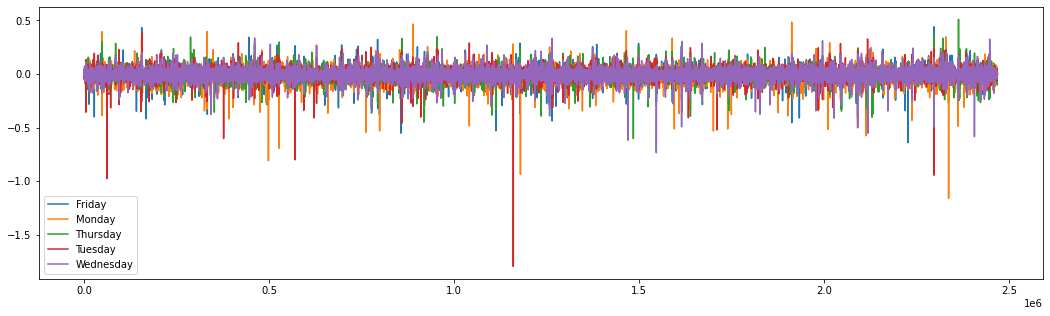

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
data_rend_gap = df.groupby('Day_week')['Rendimientos_gap']
data_rend_gap.plot(legend=True)
plt.show()

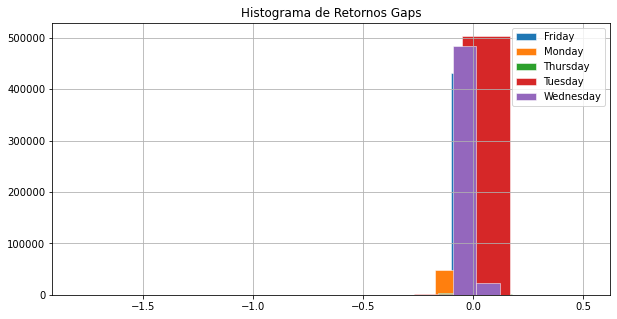

In [11]:
plt.figure(figsize=(10, 5))
data_rend_gap = df.groupby('Day_week')['Rendimientos_gap']
data_rend_gap.hist(legend=True,bins=10, linewidth=0.5, edgecolor="white")
plt.title('Histograma de Retornos Gaps')
plt.show()

In [12]:
data_rend_gap_mean = df.groupby('Day_week')['Rendimientos_gap'].mean()

In [13]:
#Concluimos que los días Martes son los días con mayores rendimientos entre gaps. 
data_rend_gap_mean.sort_values(ascending=False).keys()[0]

'Tuesday'

***

## Rendimientos Intradiarios

In [14]:
#Calculamos la columna para el rendimiento Intradiario
df = df.assign(Rendimientos_intradiario=np.log(df.Close/df.Open).groupby(df.Ticker).fillna(0))

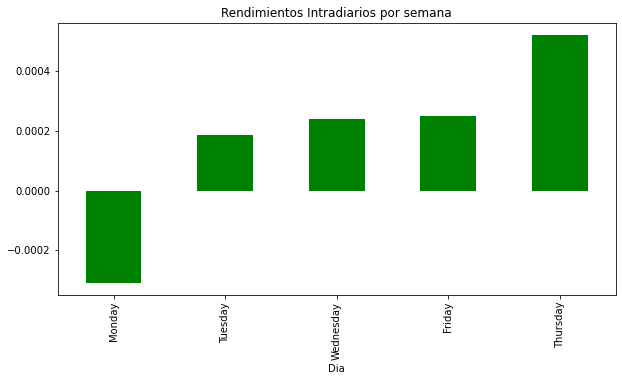

In [15]:
plt.figure(figsize=(10, 5))
data_rend_intra = df.groupby('Day_week')['Rendimientos_intradiario'].mean().sort_values(ascending=True)
data_rend_intra.plot(legend=False,kind='bar',color='green')
plt.xlabel('Dia')
plt.title('Rendimientos Intradiarios por semana')
plt.show()

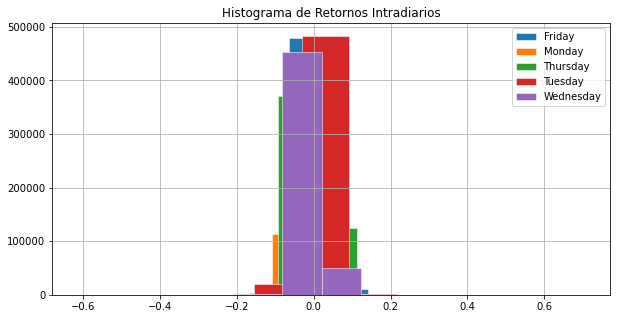

In [16]:
plt.figure(figsize=(10, 5))
data_rend_intra2 = df.groupby('Day_week')['Rendimientos_intradiario']
data_rend_intra2.hist(legend=True,bins=10, linewidth=0.5, edgecolor="white")
plt.title('Histograma de Retornos Intradiarios')
plt.show()

In [17]:
data_rend_intra_mean = df.groupby('Day_week')['Rendimientos_intradiario'].mean()

In [18]:
#Concluimos que los días Jueves son los días con mayores rendimientos intradiarios. 
data_rend_intra_mean.sort_values(ascending=False).keys()[0]

'Thursday'

***

## Rendimientos por Sector/Industria

In [19]:
#Calculamos la columna variaciones para el rendimiento direccionado para sector. 
df = df.assign(Variaciones= df['Adj Close'].pct_change().groupby(df.Ticker).fillna(0))

In [20]:
data_rend_sector = df.groupby('Sector')['Variaciones'].mean()

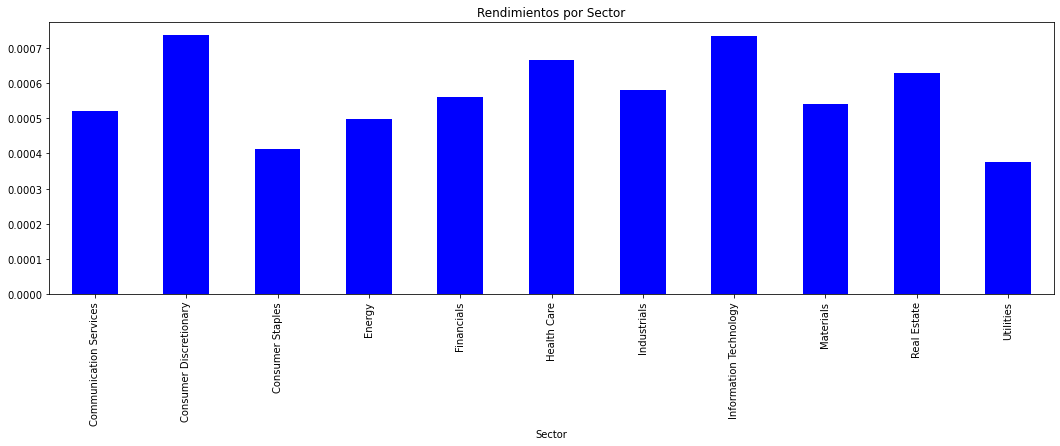

In [21]:
plt.figure(figsize=(18, 5))
data_rend_sector.plot(legend=False,kind='bar',color='b')
plt.title('Rendimientos por Sector')
plt.show()

In [22]:
#Calculamos el rendimiento por sector y obtenemos que el sector que otorgó los mejores rendimientos. 
data_rend_sector.sort_values(ascending=False).keys()[0]

'Consumer Discretionary'

***

## Análisis sobre la volatilidad del S&P500

In [11]:
#VIX = Volatility based on S&P 500 index
#GSPC = Stock market index tracking the stock performance of 500 large companies in the United States (S&P 500)

In [23]:
data_volatilidad = pd.DataFrame()
lista_volatilidad = ['^VIX', '^GSPC']
for indice in lista_volatilidad:
    data = yf.download(indice, start="2000-01-01", end="2021-12-31",progress=False)
    data.reset_index(inplace=True)
    data['Ticker'] = indice
    data_volatilidad = pd.concat([data,data_volatilidad],ignore_index=True)

In [24]:
data_volatilidad['Date'] = pd.to_datetime(data_volatilidad['Date'])

In [25]:
data_volatilidad['Year'] = data_volatilidad['Date'].dt.year

In [26]:
data_volatilidad = data_volatilidad.assign(Retornos= data_volatilidad['Adj Close'].pct_change().groupby(data_volatilidad.Ticker).fillna(0))

In [27]:
v_tickers = data_volatilidad['Ticker'].unique().tolist()
for ticker in v_tickers:
    data_volatilidad = data_volatilidad.drop(data_volatilidad[data_volatilidad['Ticker'] == ticker]['Retornos'].index[0])

In [28]:
data_vol2 = data_volatilidad.groupby(['Ticker','Year'])['Retornos'].mean()

In [29]:
#Años donde más creció el VIX. Muy interesante observar la vinculación con distintas crisis económicas en USA. 
data_vol2['^VIX'].sort_values(ascending=False)

Year
2018    0.008810
2007    0.006211
2020    0.006077
2008    0.005368
2011    0.004679
2014    0.004107
2015    0.003613
2021    0.003152
2002    0.002377
2016    0.001984
2010    0.001899
2000    0.001864
2006    0.001590
2017    0.001449
2013    0.001292
2001    0.001022
2005    0.001003
2012    0.000848
2019    0.000423
2004   -0.000085
2009   -0.000846
2003   -0.001015
Name: Retornos, dtype: float64

In [30]:
ajuste_vix = data_volatilidad[data_volatilidad['Ticker'] == '^VIX']['Adj Close'] * 100

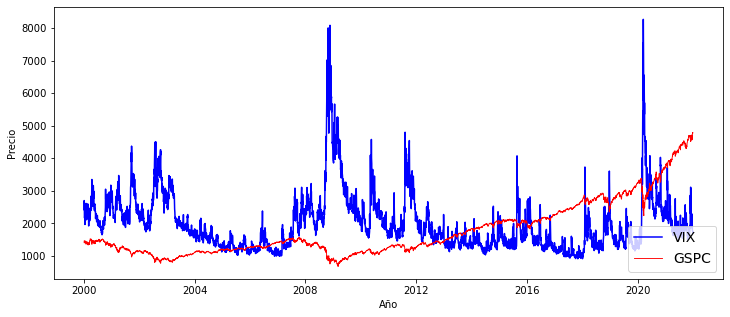

In [31]:
#Este gráfico es muy elocuente. Hay una relación INVERSA entre ambos índices.
plt.figure(figsize=(12, 5))
f1 = plt.plot(data_volatilidad[data_volatilidad['Ticker'] == '^VIX']['Date'], ajuste_vix, c = 'b', ls = '-', lw = 1.5)
f2 = plt.plot(data_volatilidad[data_volatilidad['Ticker'] == '^GSPC']['Date'], data_volatilidad[data_volatilidad['Ticker'] == '^GSPC']['Adj Close'], c = 'r', ls = 'solid', lw = 0.9)
plt.xlabel('Año')
plt.ylabel('Precio')
plt.legend(['VIX', 'GSPC'], loc = 'lower right', fontsize = 14)
plt.show()

In [32]:
returns_sp500 = data_volatilidad[data_volatilidad['Ticker'] == '^GSPC']['Retornos']
returns_vix = data_volatilidad[data_volatilidad['Ticker'] == '^VIX']['Retornos']

In [33]:
#Analizamos los rendimientos para ver la varianza
print('sp500_returns:', returns_sp500.var()*100)

sp500_returns: 0.015301732628832153


In [34]:
print('vix_returns:', returns_vix.var()*100)

vix_returns: 0.5591059547162166


***

## Definición de cartera de inversión

In [35]:
# Dataframe 2017 al 2021
df_2 = pd.DataFrame()
for ticker,sector in zip(lista_tickers,lista_sector):
    data = yf.download(ticker, start="2017-01-01", end="2021-12-31",progress=False)
    data.reset_index(inplace=True)
    data['Ticker'] = ticker
    data['Sector'] = sector
    df_2 = pd.concat([data,df_2],ignore_index=True)


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted

1 Failed download:
- CEG: Data doesn't exist for startDate = 1483225200, endDate = 1640905200


In [36]:
df_2 = df_2.assign(Retornos_ajustados= df_2['Adj Close'].pct_change().groupby(df_2.Ticker).fillna(0))

In [37]:
df2_rendimiento = df_2.groupby('Ticker')['Retornos_ajustados'].mean()

In [38]:
#Saco las veinte (20) empresas que mejores rendimientos tuvieron en promedio en los últimos años hasta el 31.12.2021
list_ren = df2_rendimiento.sort_values(ascending=False).head(20).keys().tolist()

In [39]:
df2_desvio= df_2.groupby('Ticker')['Retornos_ajustados'].std()

In [40]:
#Aquí realizo un pequeño análisis. Quiero saber cuáles fueron las 10 empresas con mayor volatilidad en sus retornos.
#*** Tecnicamente, van a haber varias coincidencias con la lista creada en el paso anterior. Hay una relación positiva entre
#riesgo (Volatilidad) y Rendimientos. 
list_ds = df2_desvio.sort_values(ascending=False).head(10).keys().tolist()

In [41]:
#Esta es mi pequeña excepción para poder aconsejar sobre las empresas elegidas. A los 20 mejores rendimientos en promedio, voy
#a establecer como requerimiento que no estén entre las 10 empresas con mayor riesgo, o también mayor volatilidad. 
lista_recomendacion = []
for x in list_ren:
    if x not in list_ds:
        lista_recomendacion.append(x)
    else:
        pass

In [42]:
df2_rend_sector= df_2.groupby('Sector')['Retornos_ajustados'].mean()

In [43]:
df2_rend_sector.sort_values(ascending=False)

Sector
Consumer Discretionary    0.001641
Health Care               0.001288
Communication Services    0.001078
Information Technology    0.000889
Financials                0.000881
Materials                 0.000796
Industrials               0.000748
Real Estate               0.000590
Consumer Staples          0.000510
Utilities                 0.000197
Energy                    0.000038
Name: Retornos_ajustados, dtype: float64

In [44]:
dict_sector = {}
for x in lista_sector:
    dict_sector[x] = 0

In [45]:
for x in lista_recomendacion:
    dict_sector[df_2[df_2['Ticker'] == x]['Sector'].unique()[0]] += 1
    print(x + ' ' + df_2[df_2['Ticker'] == x]['Sector'].unique()[0])

NVR Consumer Discretionary
NFLX Communication Services
AAP Consumer Discretionary
BLK Financials
LOW Consumer Discretionary
ENPH Information Technology
WHR Consumer Discretionary
SIVB Financials
AIZ Financials
MRNA Health Care


In [46]:
#Creo Dataframe para ver cómo esta distribuida la cartera por Industria.
df2_sector = pd.DataFrame([[key, dict_sector[key]] for key in dict_sector.keys()], columns=['Sector', 'Cantidad'])

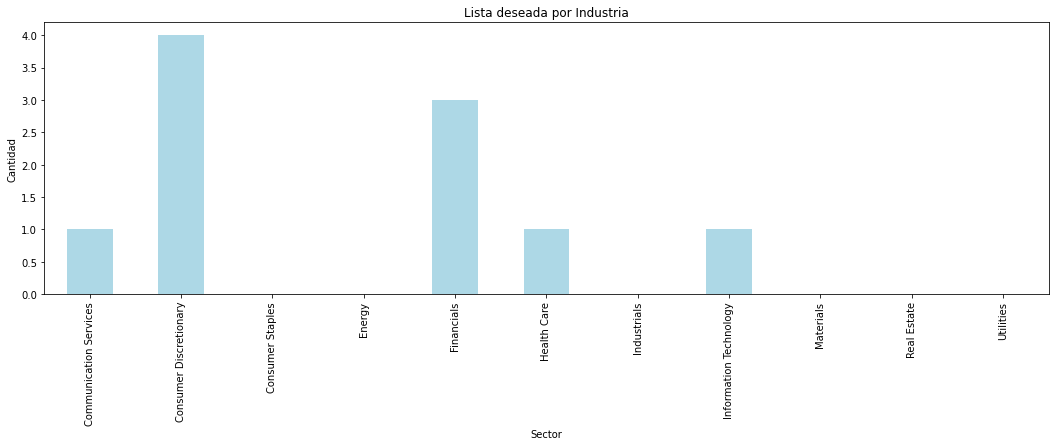

In [47]:
plt.figure(figsize=(18, 5))
df2_sector.groupby('Sector')['Cantidad'].sum().plot(legend=False,kind='bar',color='lightblue')
plt.ylabel('Cantidad')
plt.title('Lista deseada por Industria')
plt.show()

In [48]:
#Con el fin de diversificar, voy a quitar una de las 4 empresas que están dentro de la industria Consumer Discretionary.
#De esta forma, me quedo con 9 empresas acorde a la consigna solicitada. Criterio de eliminación: Mayor volatilidad (std).
#Elimino 'NVR'.
list_consumer_discretionary = ['NVR','AAP','LOW','WHR']
for ticker in list_consumer_discretionary:
    print(df2_desvio[df2_desvio.keys() == ticker])

Ticker
NVR    0.178738
Name: Retornos_ajustados, dtype: float64
Ticker
AAP    0.166408
Name: Retornos_ajustados, dtype: float64
Ticker
LOW    0.122457
Name: Retornos_ajustados, dtype: float64
Ticker
WHR    0.145902
Name: Retornos_ajustados, dtype: float64


In [49]:
lista_recomendacion.remove('NVR')

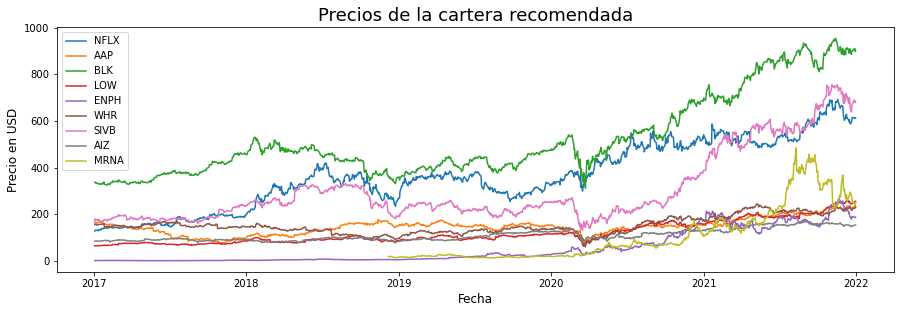

In [50]:
plt.figure(figsize=(15,4.5))
for ticker in lista_recomendacion:
    plt.plot(df_2[df_2['Ticker'] == ticker]['Date'].values,df_2[df_2['Ticker'] == ticker]['Adj Close'].values,  label=ticker)
plt.title('Precios de la cartera recomendada',fontsize=18)
plt.xlabel('Fecha',fontsize=12)
plt.ylabel('Precio en USD',fontsize=12)
plt.legend(lista_recomendacion, loc='upper left')
plt.savefig('plot_precios.png', dpi=300, bbox_inches='tight')
plt.show()

***

## Análisis sobre la correlación de activos que componen la cartera recomendada

In [51]:
df_corr = pd.DataFrame(columns=lista_recomendacion)

In [52]:
df_2['Date'] = pd.to_datetime(df_2['Date'])

In [53]:
df_filtro_corr = df_2[df_2['Date'] >= '2018-12-07']

In [54]:
for x in df_corr:
        df_corr[x] = df_filtro_corr[df_filtro_corr['Ticker'] == x]['Retornos_ajustados'].values

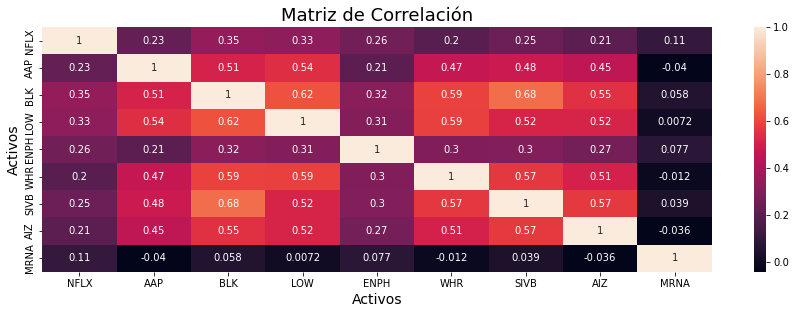

In [55]:
#Matriz de correlación para la cartera recomendada
import seaborn as sns
correlation_mat = df_corr.corr()
plt.figure(figsize=(15,4.5))
sns.heatmap(correlation_mat, annot = True)
plt.title('Matriz de Correlación', fontsize=18)
plt.xlabel('Activos',fontsize=14)
plt.ylabel('Activos',fontsize=14)
plt.show()